In [1]:
from main import train_model
import pandas as pd
import numpy as np
import random
from sklearn.metrics import accuracy_score, f1_score
import sklearn
import matplotlib.pyplot as plt
import datetime
import torch
import csv
from imblearn.over_sampling import SMOTE
from collections import Counter

from load_data import load_preproc_data, load_trte_partition
from utils import one_hot_tensor, cal_sample_weight 
from models import init_model_dict, init_optim
from train_test import prepare_trte_data, gen_trte_adj_mat
from train_test import train_1_epoch, test_VCDN
import copy

from utils import print_dict
from temporaries import findInteractionsSelf, findInteractionsCross, label_specific_acc

import cufflinks as cf
import pathlib
%matplotlib inline

import shap
import lime
import re

In [2]:
#We set the all charts as public
cf.set_config_file(sharing='public',theme='pearl',offline=False)
cf.go_offline()

cwd = pathlib.Path.cwd()

In [3]:
RUN_TITLE = "ANOVA top 1000 features selected greedily with correlation below 0.8 \nThis run includes all 3 GCNs"
RUN_TITLE_SHORT = "brca_full"
# SEED can be "random" or integer, if integer, it will be used as the seed for random, numpy, torch, and cuda
SEED = "random" 

# pre-processed data
mrna = "/data/users/bs16b001/R/TCGA BRCA/mrna_top1000.csv"
meth = "/data/users/bs16b001/R/TCGA BRCA/meth_top1000.csv"
mirna = "/data/users/bs16b001/R/TCGA BRCA/mirna_anova.csv"
meta_csv = "/data/users/bs16b001/R/TCGA BRCA/PAM50_subtype.csv"
trte_partition_file = "/data/users/bs16b001/R/TCGA BRCA/trte_partition.txt"

# change label from text to integer
label_dict = {'Normal':0, 'Basal':1, 'Her2':2, 'LumA':3, 'LumB':4}

# load preprocessed data from csv
#load_list - list of csv files to laod. The -2 position should be meta_csv and -1 position should be trte_partition_file
load_list = [mrna, meth, mirna, meta_csv, trte_partition_file]
GCN_names = ["mRNA","methylation","miRNA"]

COMBINER = "VCDN" # Can take values "VCDN", "FullyConnected", or False.
#Use False when only a sinngle GCN output is to be generated and

doSMOTE = True # Boolean

# MORONET training parameters
num_epoch = 300
test_interval = 30
lr = 5e-4
weight_decay = 5e-4
dropout = 0.25
adj_parameter = 1 # average number of edge per node in adj matrix

# VERBOSE setting for print results
VERBOSE = 2 #0, only print final result; 1, only testing result; 2, training and testing result
OUTPUT_FILES = False #Boolean to determine whether to output loss and metrics as csv files
MAKE_PLOTS = False #Boolean to determine whether to output loss and metrics as plots in png format
REPEATS = 1 #Integer, how many times to independently train the model

In [4]:
#losses_df, metrics_df = train_model(load_list=load_list, label_dict=label_dict, GCN_names=GCN_names, COMBINER=COMBINER,
#        SEED=SEED, num_epoch=num_epoch, test_interval=test_interval, lr=lr, weight_decay=weight_decay, 
#        dropout=dropout, adj_parameter=adj_parameter, VERBOSE=VERBOSE, doSMOTE = doSMOTE,
#        RUN_TITLE=RUN_TITLE, RUN_TITLE_SHORT=RUN_TITLE_SHORT,
#        OUTPUT_FILES=OUTPUT_FILES, MAKE_PLOTS=MAKE_PLOTS)

In [4]:
if COMBINER: GCN_names.append(COMBINER)
    
# assign GPU number
CUDA_DEVICE = 0
cuda = True if torch.cuda.is_available() else False

if cuda:
    Print("CUDA Device in use")

# Set random seed
if SEED == "random":
    SEED = random.randint(0,100000)
print("SEED = ", SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.manual_seed(SEED)
if cuda:
    torch.cuda.manual_seed(SEED)
    torch.cuda.set_device(CUDA_DEVICE)

# load preprocessed data from csv

num_class = len(label_dict)
data_list, labels, patient_id, feat_name_list = load_preproc_data(load_list[:-2], load_list[-2], label_dict)
# load tr/te partition
tr_idx, te_idx = load_trte_partition(load_list[-1], patient_id)

SEED =  5621


In [6]:
""" Prepare data and model for training and testing
"""
# data to tensor
data_tensor_list = []
for i in range(len(data_list)):
    data_tensor_list.append(torch.FloatTensor(data_list[i]))
    if cuda:
        data_tensor_list[i] = data_tensor_list[i].cuda()

# generate training and testing data
data_tr_list, data_trte_list, trte_idx, labels_trte = prepare_trte_data(data_tensor_list, labels, tr_idx, te_idx)


labels_tr_tensor = torch.LongTensor(labels_trte[trte_idx["tr"]])

# Here we modify the training data set using SMOTE. We have only changed the training data.
# While testing, we use training data, but only the real ones, not the synthesised ones
data_tr_list_nosmote = copy.deepcopy(data_tr_list)
if doSMOTE:
    sm = SMOTE(random_state = SEED)
    for i in range(len(data_tr_list)):
        data_tr_list[i], labels = sm.fit_sample(data_tr_list[i], labels_tr_tensor)
        data_tr_list[i] = torch.FloatTensor(data_tr_list[i])
    labels_tr_tensor = torch.LongTensor(labels)
    onehot_labels_tr_tensor = one_hot_tensor(labels_tr_tensor, num_class)

    sample_weight_tr = cal_sample_weight(labels_tr_tensor.numpy(), num_class)
    sample_weight_tr =  torch.FloatTensor(sample_weight_tr)
else:
    onehot_labels_tr_tensor = one_hot_tensor(labels_tr_tensor, num_class)
    sample_weight_tr = cal_sample_weight(labels_trte[trte_idx["tr"]], num_class)
    sample_weight_tr =  torch.FloatTensor(sample_weight_tr)

if cuda:
    labels_tr_tensor = labels_tr_tensor.cuda()
    onehot_labels_tr_tensor = onehot_labels_tr_tensor.cuda()
    sample_weight_tr = sample_weight_tr.cuda()

# calculate adjacency matrix
adj_tr_list, adj_te_list = gen_trte_adj_mat(data_tr_list, data_trte_list, trte_idx, adj_parameter)

# Calculating the dimensions for the GCN and VCDN inputs
dim_list = [each.shape[1] for each in data_tr_list] # Input dimension of GCN
dim_he_list = dim_list                              # Hidden layer  dimension of GCN
dim_hvcdn = num_class**len(dim_list)                # Input dimension of VCDN

# model and optimization
model_dict = init_model_dict(num_class, dim_list, dim_he_list, dim_hvcdn, GCN_names, COMBINER, gcn_dropout=dropout)

for m in model_dict:
    if cuda:
        model_dict[m].cuda()
optim_dict = init_optim(model_dict, dim_list, GCN_names, COMBINER, lr, weight_decay)  

This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)


In [9]:
#Some necessary lists
ground_truth_test = labels_trte[trte_idx["te"]]
ground_truth_train = labels_tr_tensor.numpy()
counter_test = Counter(ground_truth_test)
counter_train = Counter(ground_truth_train)
train_accuracies_dict = {key:[] for key in label_dict}
test_accuracies_dict = {key:[] for key in label_dict}

In [8]:
""" Training and testing
"""
losses = [[] for _ in range(len(GCN_names))] 
test_ACC = []
test_F1 = [] 
train_ACC = []
train_F1 = []
print("\nTraining...")
for epoch in range(num_epoch+1):
    """ Train one epoch
    """
    tr_loss_dict, train_prob = train_1_epoch(data_tr_list, adj_tr_list, labels_tr_tensor, 
                                       onehot_labels_tr_tensor, sample_weight_tr, model_dict, optim_dict,
                                       GCN_names, COMBINER)
    if VERBOSE >= 2:
        print("Epoch {:d}, Train loss: {:}".format(epoch, print_dict(tr_loss_dict, print_format=".2e")))

    for i in range(len(GCN_names)):
        losses[i].append(tr_loss_dict[GCN_names[i]])

    """ Testing
    """
    if epoch % test_interval == 0:
        te_prob = test_VCDN(data_trte_list, adj_te_list, trte_idx["te"], model_dict, GCN_names, COMBINER)
        te_acc = accuracy_score(labels_trte[trte_idx["te"]], te_prob.argmax(1))
        te_f1 = f1_score(labels_trte[trte_idx["te"]], te_prob.argmax(1), average='weighted')
        train_acc = accuracy_score(labels_tr_tensor, train_prob.argmax(1))
        train_f1 = f1_score(labels_tr_tensor, train_prob.argmax(1), average='weighted')
        if VERBOSE >= 1 or (epoch == num_epoch):                    #Second condition to print values at the end of run
            print("\nTest: Epoch {:d}".format(epoch))
            print("Train Accuracy: {:.4f}   Test ACC: {:.4f}".format(train_acc, te_acc))
            print("Train F1: {:.4f}         Test F1: {:.4f}".format(train_f1, te_f1))
            print()

            # Checking label specific accuracies
            # in order to determine if there is an issue due to an unbalanced label distribution
            accuracies_test = label_specific_acc(ground_truth_test, te_prob.argmax(1))
            accuracies_train = label_specific_acc(ground_truth_train, train_prob.argmax(1))
            #print("Here, we have the label specific accuracies:\n")
            print("Label", "      ", "Train Distribution", "   ", "Train Accuracy", "   ", "Test Distribution", "   ", "Test Accuracy")
            print("-"*90)
            for each in label_dict:
                dist_train = "{:.4f}".format(counter_train[label_dict[each]]/len(ground_truth_train))
                dist_test = "{:.4f}".format(counter_test[label_dict[each]]/len(ground_truth_test))
                acc_train = "{:.4f}".format(accuracies_train[label_dict[each]])
                acc_test = "{:.4f}".format(accuracies_test[label_dict[each]])
                print(each, "\t          ", dist_train, "            ", acc_train, "            ", dist_test, "            ", acc_test)
            print() #Just a spacer. Need the extra blank line

        #Storing all metrics at test intervals
        accuracies_test = label_specific_acc(ground_truth_test, te_prob.argmax(1))
        accuracies_train = label_specific_acc(ground_truth_train, train_prob.argmax(1))
        for each in label_dict:
            train_accuracies_dict[each].append(accuracies_train[label_dict[each]])
            test_accuracies_dict[each].append(accuracies_test[label_dict[each]])
        test_ACC.append(te_acc)
        test_F1.append(te_f1)
        train_ACC.append(train_acc)
        train_F1.append(train_f1)


Training...
Epoch 0, Train loss: mRNA:9.20e-02, methylation:9.28e-02, miRNA:4.39e-02, VCDN:3.27e-01

Test: Epoch 0
Train Accuracy: 0.2000   Test ACC: 0.0543
Train F1: 0.0668         Test F1: 0.0056

Label        Train Distribution     Train Accuracy     Test Distribution     Test Accuracy
------------------------------------------------------------------------------------------
Normal 	           0.2000              0.0000              0.1359              0.0000
Basal 	           0.2000              0.0000              0.1522              0.0000
Her2 	           0.2000              1.0000              0.0543              1.0000
LumA 	           0.2000              0.0000              0.4837              0.0000
LumB 	           0.2000              0.0000              0.1739              0.0000

Epoch 1, Train loss: mRNA:1.35e+00, methylation:1.17e+00, miRNA:3.85e-02, VCDN:3.25e-01
Epoch 2, Train loss: mRNA:1.53e-01, methylation:1.43e-01, miRNA:3.53e-02, VCDN:3.23e-01
Epoch 3, Train los

Epoch 69, Train loss: mRNA:2.18e-02, methylation:2.03e-02, miRNA:1.45e-02, VCDN:2.80e-01
Epoch 70, Train loss: mRNA:2.17e-02, methylation:2.02e-02, miRNA:1.43e-02, VCDN:2.79e-01
Epoch 71, Train loss: mRNA:2.16e-02, methylation:1.99e-02, miRNA:1.44e-02, VCDN:2.76e-01
Epoch 72, Train loss: mRNA:2.11e-02, methylation:1.97e-02, miRNA:1.43e-02, VCDN:2.74e-01
Epoch 73, Train loss: mRNA:2.10e-02, methylation:1.97e-02, miRNA:1.42e-02, VCDN:2.72e-01
Epoch 74, Train loss: mRNA:2.11e-02, methylation:1.96e-02, miRNA:1.41e-02, VCDN:2.71e-01
Epoch 75, Train loss: mRNA:2.06e-02, methylation:1.92e-02, miRNA:1.38e-02, VCDN:2.69e-01
Epoch 76, Train loss: mRNA:2.12e-02, methylation:1.95e-02, miRNA:1.37e-02, VCDN:2.67e-01
Epoch 77, Train loss: mRNA:2.11e-02, methylation:1.89e-02, miRNA:1.39e-02, VCDN:2.66e-01
Epoch 78, Train loss: mRNA:2.06e-02, methylation:1.89e-02, miRNA:1.36e-02, VCDN:2.63e-01
Epoch 79, Train loss: mRNA:1.99e-02, methylation:1.88e-02, miRNA:1.35e-02, VCDN:2.62e-01
Epoch 80, Train loss:

Epoch 146, Train loss: mRNA:1.30e-02, methylation:1.24e-02, miRNA:8.98e-03, VCDN:1.11e-01
Epoch 147, Train loss: mRNA:1.32e-02, methylation:1.28e-02, miRNA:9.10e-03, VCDN:1.09e-01
Epoch 148, Train loss: mRNA:1.37e-02, methylation:1.22e-02, miRNA:9.07e-03, VCDN:1.08e-01
Epoch 149, Train loss: mRNA:1.39e-02, methylation:1.19e-02, miRNA:9.00e-03, VCDN:1.07e-01
Epoch 150, Train loss: mRNA:1.36e-02, methylation:1.14e-02, miRNA:8.84e-03, VCDN:1.05e-01

Test: Epoch 150
Train Accuracy: 0.9646   Test ACC: 0.8641
Train F1: 0.9642         Test F1: 0.8673

Label        Train Distribution     Train Accuracy     Test Distribution     Test Accuracy
------------------------------------------------------------------------------------------
Normal 	           0.2000              0.9665              0.1359              0.8000
Basal 	           0.2000              1.0000              0.1522              0.9643
Her2 	           0.2000              1.0000              0.0543              0.9000
LumA 	      

Epoch 215, Train loss: mRNA:1.07e-02, methylation:1.14e-02, miRNA:7.03e-03, VCDN:5.07e-02
Epoch 216, Train loss: mRNA:1.05e-02, methylation:1.08e-02, miRNA:7.17e-03, VCDN:4.88e-02
Epoch 217, Train loss: mRNA:9.80e-03, methylation:1.00e-02, miRNA:7.09e-03, VCDN:4.80e-02
Epoch 218, Train loss: mRNA:9.93e-03, methylation:1.12e-02, miRNA:7.07e-03, VCDN:4.80e-02
Epoch 219, Train loss: mRNA:1.03e-02, methylation:9.60e-03, miRNA:7.07e-03, VCDN:4.66e-02
Epoch 220, Train loss: mRNA:1.06e-02, methylation:1.07e-02, miRNA:7.05e-03, VCDN:4.65e-02
Epoch 221, Train loss: mRNA:1.09e-02, methylation:9.56e-03, miRNA:7.10e-03, VCDN:4.57e-02
Epoch 222, Train loss: mRNA:1.03e-02, methylation:1.01e-02, miRNA:7.17e-03, VCDN:4.55e-02
Epoch 223, Train loss: mRNA:1.01e-02, methylation:9.75e-03, miRNA:6.95e-03, VCDN:4.51e-02
Epoch 224, Train loss: mRNA:1.02e-02, methylation:9.69e-03, miRNA:6.99e-03, VCDN:4.45e-02
Epoch 225, Train loss: mRNA:1.00e-02, methylation:9.36e-03, miRNA:6.94e-03, VCDN:4.48e-02
Epoch 226,

Epoch 291, Train loss: mRNA:8.27e-03, methylation:8.11e-03, miRNA:6.22e-03, VCDN:2.65e-02
Epoch 292, Train loss: mRNA:8.12e-03, methylation:7.16e-03, miRNA:6.19e-03, VCDN:2.68e-02
Epoch 293, Train loss: mRNA:7.74e-03, methylation:7.68e-03, miRNA:6.13e-03, VCDN:2.62e-02
Epoch 294, Train loss: mRNA:8.00e-03, methylation:7.67e-03, miRNA:6.06e-03, VCDN:2.60e-02
Epoch 295, Train loss: mRNA:7.66e-03, methylation:7.54e-03, miRNA:6.21e-03, VCDN:2.54e-02
Epoch 296, Train loss: mRNA:7.65e-03, methylation:7.68e-03, miRNA:6.07e-03, VCDN:2.55e-02
Epoch 297, Train loss: mRNA:8.05e-03, methylation:7.42e-03, miRNA:6.14e-03, VCDN:2.57e-02
Epoch 298, Train loss: mRNA:8.08e-03, methylation:7.39e-03, miRNA:6.06e-03, VCDN:2.51e-02
Epoch 299, Train loss: mRNA:7.91e-03, methylation:7.55e-03, miRNA:6.13e-03, VCDN:2.54e-02
Epoch 300, Train loss: mRNA:8.18e-03, methylation:7.07e-03, miRNA:6.22e-03, VCDN:2.51e-02

Test: Epoch 300
Train Accuracy: 0.9847   Test ACC: 0.8641
Train F1: 0.9847         Test F1: 0.8632


In [9]:
model_dict

{'E1': GCN_E_2(
   (gc1): GraphConvolution()
   (gc2): GraphConvolution()
 ), 'mRNA': Classifier_1(
   (clf): Sequential(
     (0): Linear(in_features=1000, out_features=5, bias=True)
   )
 ), 'E2': GCN_E_2(
   (gc1): GraphConvolution()
   (gc2): GraphConvolution()
 ), 'methylation': Classifier_1(
   (clf): Sequential(
     (0): Linear(in_features=1000, out_features=5, bias=True)
   )
 ), 'E3': GCN_E_2(
   (gc1): GraphConvolution()
   (gc2): GraphConvolution()
 ), 'miRNA': Classifier_1(
   (clf): Sequential(
     (0): Linear(in_features=257, out_features=5, bias=True)
   )
 ), 'VCDN': VCDN(
   (model): Sequential(
     (0): Linear(in_features=125, out_features=125, bias=True)
     (1): LeakyReLU(negative_slope=0.25)
     (2): Linear(in_features=125, out_features=5, bias=True)
   )
 )}

In [10]:
from utils import gen_adj_mat_tensor, gen_test_adj_mat_tensor, cal_adj_mat_parameter

def pred_funct(sample_numpy):
    
    sample_torch = torch.FloatTensor(sample_numpy)
    if len(sample_torch)==1: sample_torch = sample_torch.unsqueeze(0)
    
    
    data_full = torch.cat(tuple(each for each in data_tr_list), dim=1)
    data_combined = torch.cat((data_full, sample_torch), dim=0)
    indices = list(range(data_full.shape[0], data_combined.shape[0]))
    
    lengths = [each.shape[1] for each in data_tr_list]
    data_combined_list = []
    adj_list = []
    end = 0
    for i in range(len(lengths)):
        start = end
        end = start + lengths[i]
        data_combined_list.append(data_combined[:,start:end])
        adj_parameter_adaptive = cal_adj_mat_parameter(adj_parameter, data_tr_list[i])
        adj_list.append(gen_adj_mat_tensor(data_combined_list[i], adj_parameter_adaptive))
    
    predictions = test_VCDN(data_combined_list, adj_list, indices, model_dict, GCN_names, COMBINER)
    
    return predictions

In [12]:
import lime
import lime.lime_tabular

In [13]:
data_full = np.array(torch.cat(tuple(each for each in data_trte_list), dim=1))
feature_names = [name for sublist in feat_name_list for name in sublist]

explainer = lime.lime_tabular.LimeTabularExplainer(data_full, feature_names=feature_names, 
                                                   class_names=label_dict.values(), discretize_continuous=True)

In [149]:
i = 584
row_across_data = np.array(torch.cat(tuple(each[i,:] for each in data_trte_list), dim=0))

exp = explainer.explain_instance(row_across_data, pred_funct, num_features=1000, top_labels=1)

In [150]:
exp.score

0.5366276308283378

In [ ]:
scores = {"10feat"=.12, "20feat"=.17, "100feat"=.26, "500feat"=.4256, "1000feat"=.5335}

In [43]:
exp.show_in_notebook(show_table=True, show_all=False)

In [119]:
from lime import submodular_pick
#?submodular_pick.SubmodularPick
#?lime.lime_tabular.LimeTabularExplainer.explain_instance
data_full = np.array(torch.cat(tuple(each for each in data_tr_list), dim=1))
sp_obj = submodular_pick.SubmodularPick(explainer, data_full, pred_funct, method="sample", sample_size=10, num_features=1000, num_exps_desired=5)
# The function takes two arguments for method: "full" and "sample"
# If "sample" method is used, the sample_size argument has to be mentioned which defaults to 1000

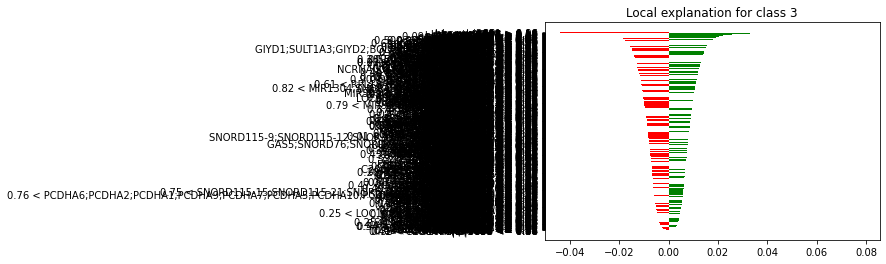

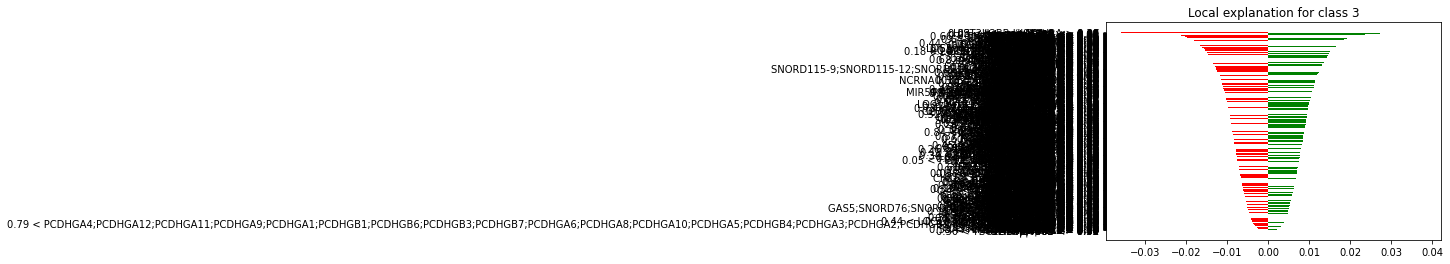

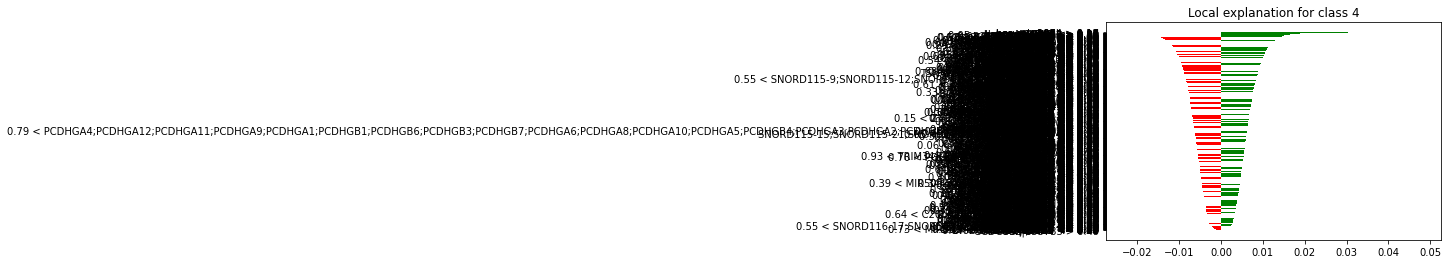

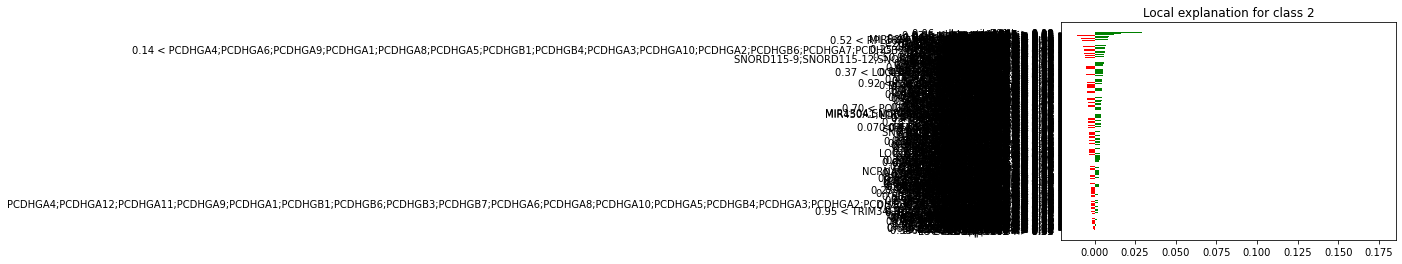

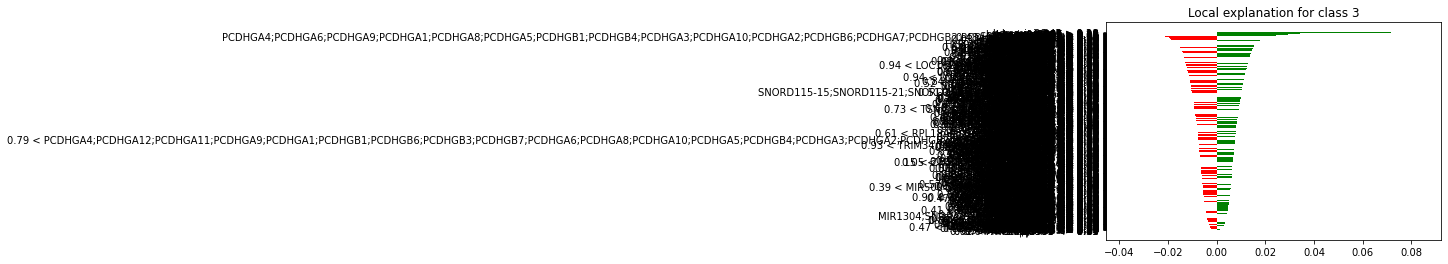

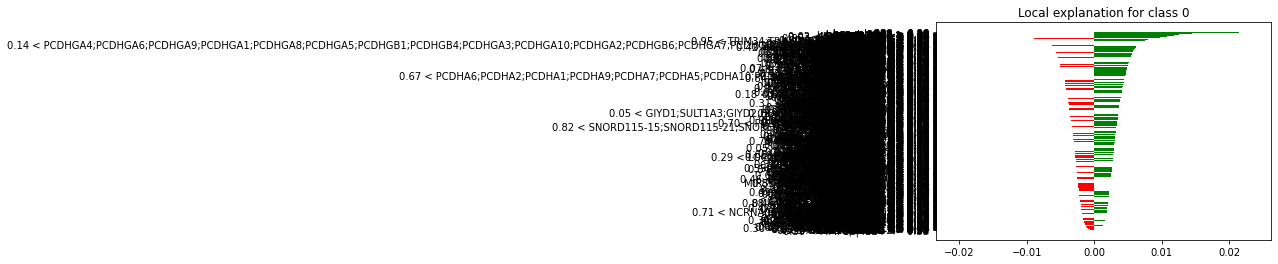

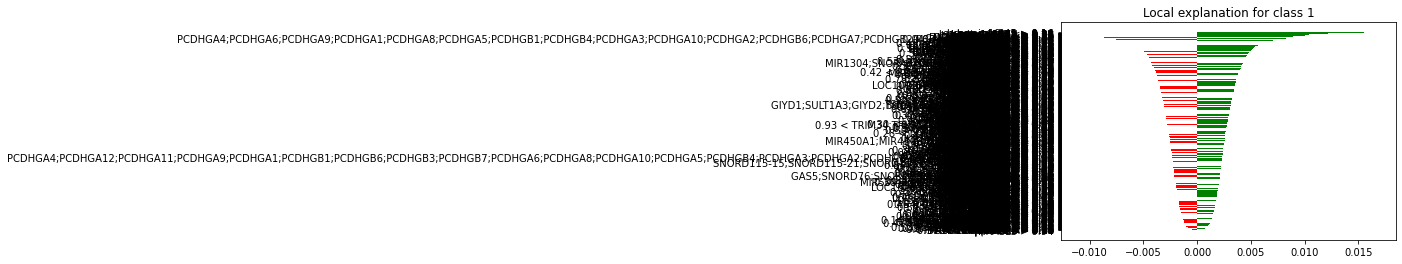

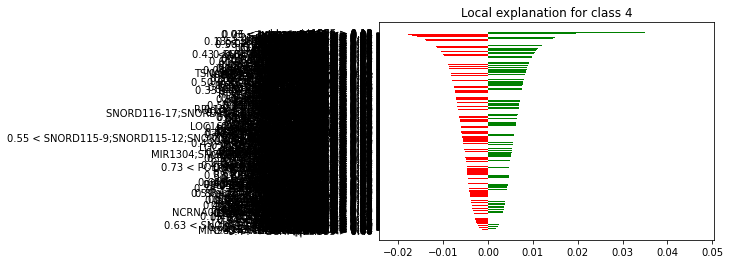

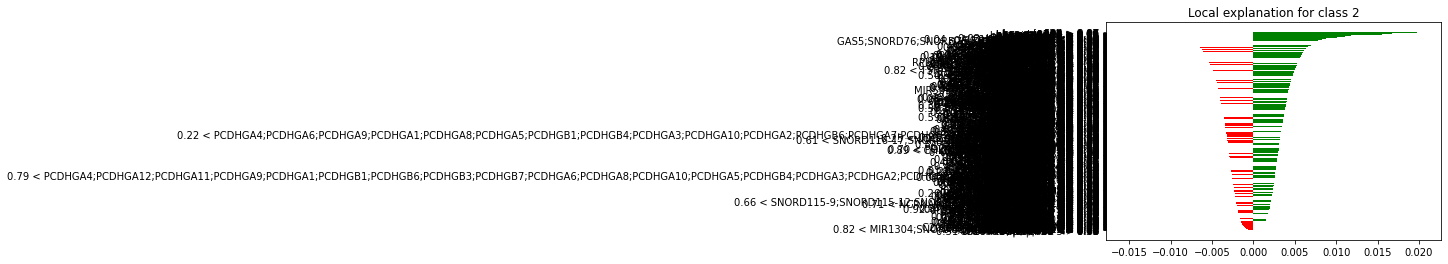

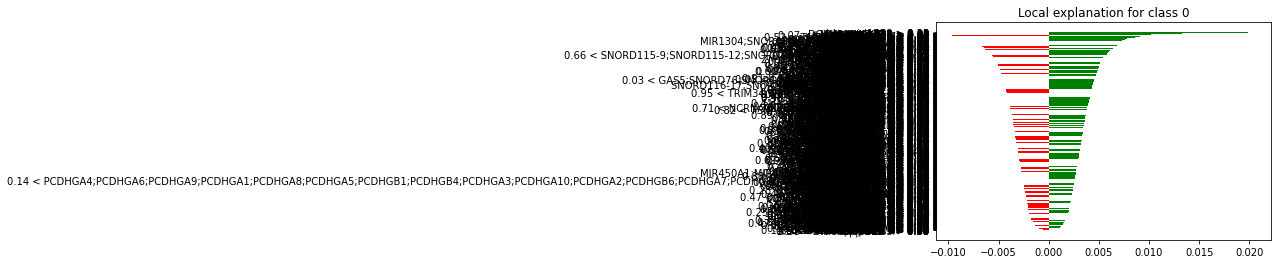

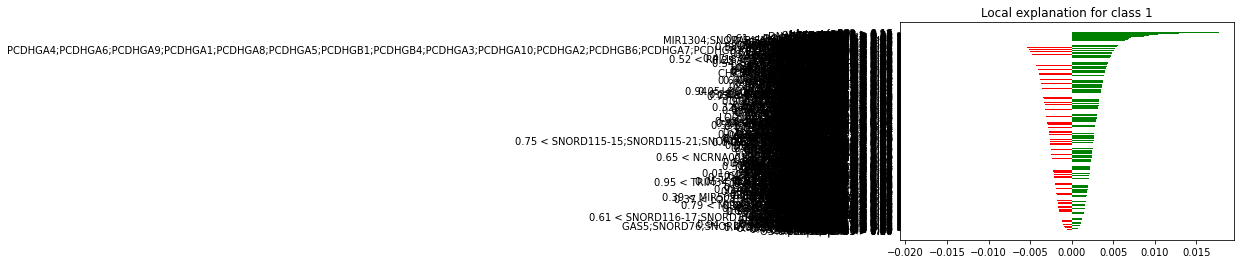

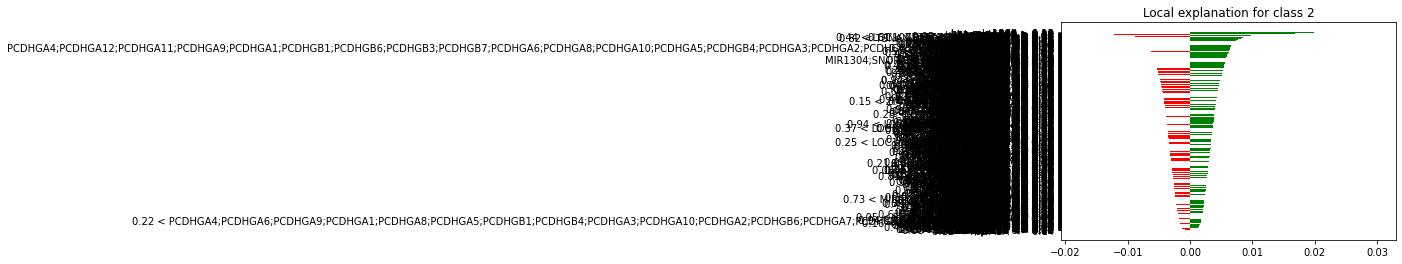

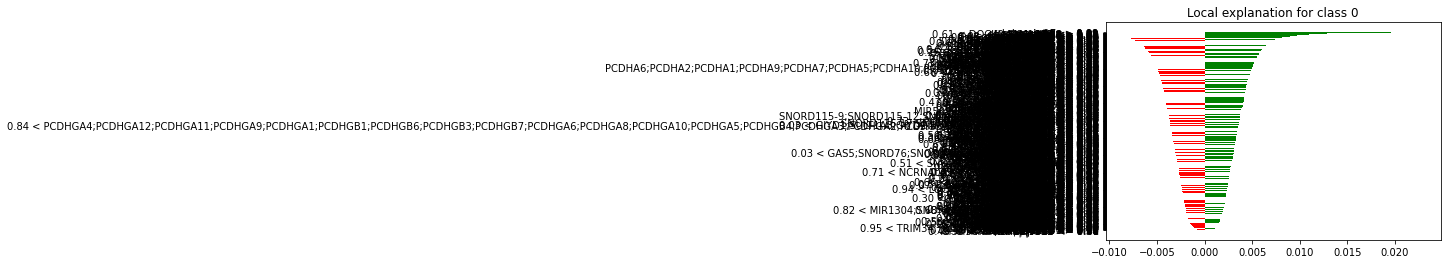

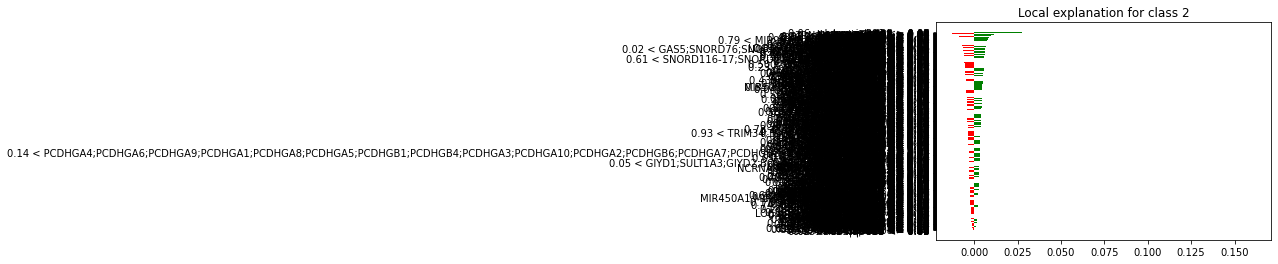

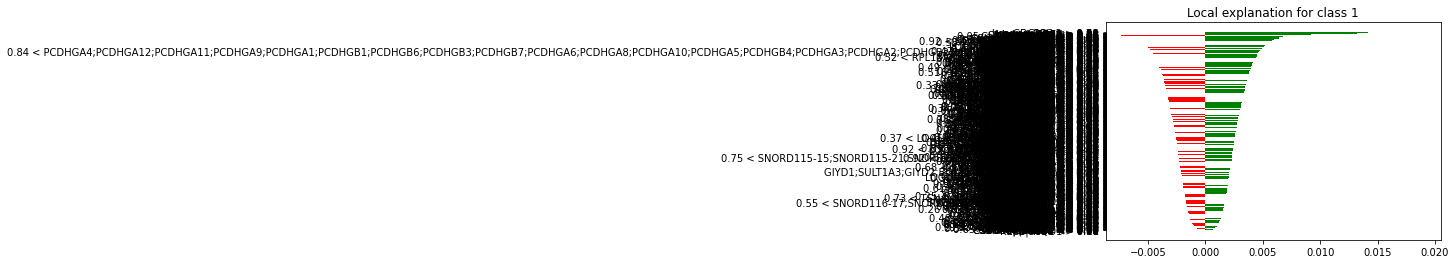

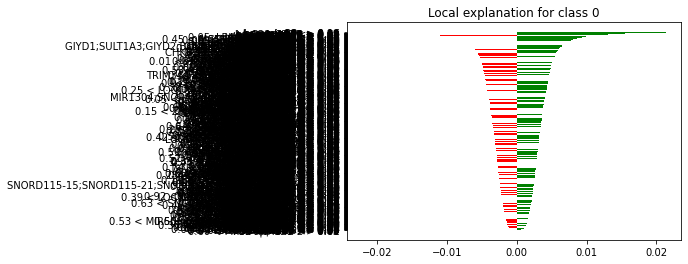

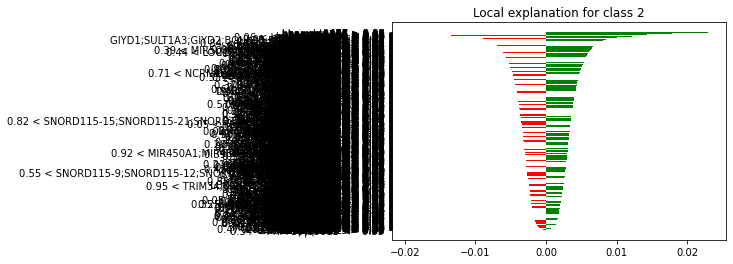

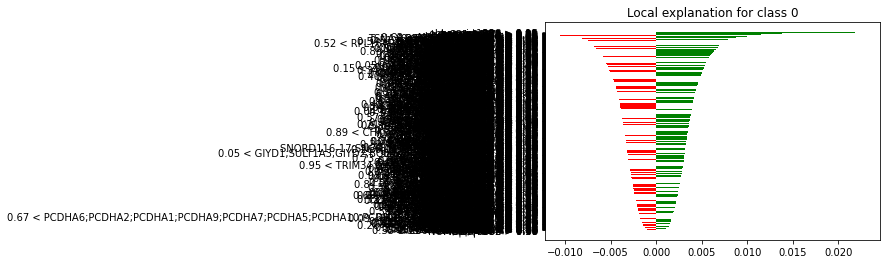

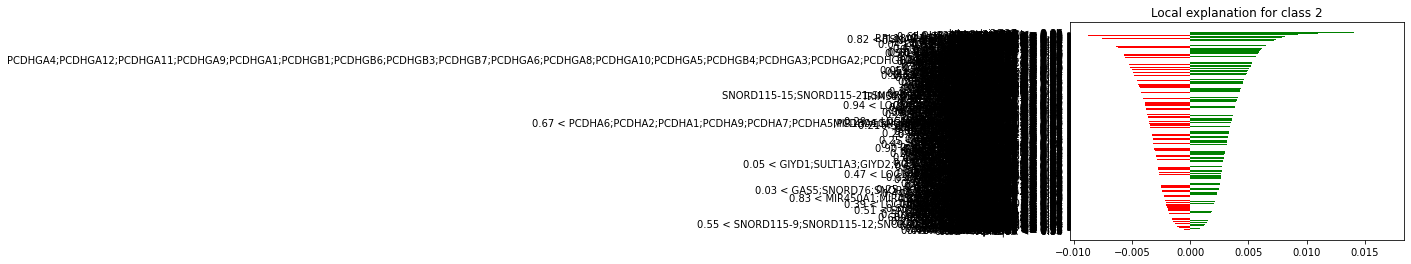

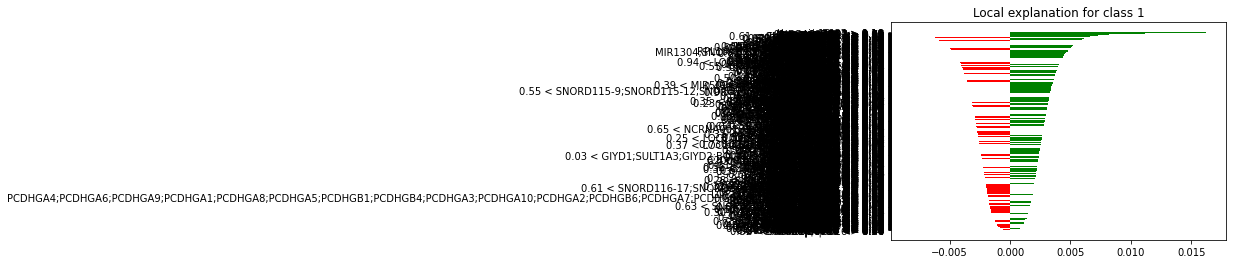

In [45]:
#Plot the explanations
#[exp.as_pyplot_figure(label=exp.available_labels()[0]) for exp in sp_obj.sp_explanations];

In [120]:
# Make it into a dataframe
W_pick=pd.DataFrame([dict(each.as_list(each.available_labels()[0])) for each in sp_obj.sp_explanations]).fillna(0)
 
W_pick['prediction'] = [each.available_labels()[0] for each in sp_obj.sp_explanations]
 
#Making a dataframe of all the explanations of sampled points
W=pd.DataFrame([dict(each.as_list(each.available_labels()[0])) for each in sp_obj.explanations]).fillna(0)
W['prediction'] = [each.available_labels()[0] for each in sp_obj.explanations]

In [121]:
W_pick

,hsa-mir-29c > 0.16,hsa-mir-26a-2 > 0.16,hsa-mir-101-1 > 0.14,hsa-mir-345 > 0.14,hsa-mir-200b > 0.12,hsa-mir-450a-2 <= 0.05,hsa-mir-2355 <= 0.05,hsa-mir-3909 > 0.21,hsa-mir-3613 > 0.13,0.04 < hsa-mir-3605 <= 0.08,...,MGC2889;HRASLS > 0.17,0.54 < SIK1|150094 <= 0.59,hsa-mir-16-2 > 0.02,0.04 < hsa-mir-101-1 <= 0.07,RBPMS > 0.67,CROCCL1|84809 <= 0.45,PRCD > 0.80,0.34 < PCDHB3|56132 <= 0.40,0.58 < TCF7L2 <= 0.60,prediction
0,0.086431,0.055405,0.054308,-0.040933,0.034396,0.028329,0.027799,-0.026293,-0.025795,-0.025554,...,0.000000,0.0000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,3
1,0.077717,0.035457,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,3
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,4
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.007500,0.000000,0.000000,0.002861,...,0.000000,0.0000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0
4,0.000000,0.000000,0.000000,0.014273,-0.009231,0.000000,0.000000,0.010443,0.000000,0.000000,...,-0.000939,0.0009,-0.00083,-0.000819,-0.000756,0.00074,0.000665,0.000571,-0.000394,2


In [122]:
W

,hsa-mir-29c > 0.16,hsa-mir-26a-2 > 0.16,hsa-mir-101-1 > 0.14,hsa-mir-345 > 0.14,hsa-mir-200b > 0.12,hsa-mir-450a-2 <= 0.05,hsa-mir-2355 <= 0.05,hsa-mir-3909 > 0.21,hsa-mir-3613 > 0.13,0.04 < hsa-mir-3605 <= 0.08,...,0.79 < LEFTY1 <= 0.81,BGLAP|632 > 0.35,0.03 < hsa-mir-320d-1 <= 0.06,0.66 < FAM90A1 <= 0.72,SIN3B > 0.68,S1PR5|53637 <= 0.26,0.62 < SCCPDH|51097 <= 0.65,ELF3|1999 > 0.70,MYO9A > 0.89,prediction
0,0.086431,0.055405,0.054308,-0.040933,0.034396,0.028329,0.027799,-0.026293,-0.025795,-0.025554,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,3
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,1
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.007500,0.000000,0.000000,0.002861,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0
3,0.000000,0.000000,0.000000,0.014273,-0.009231,0.000000,0.000000,0.010443,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,2
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0
6,-0.020003,0.006075,-0.008163,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,4
8,0.000000,0.000000,0.000000,0.000000,0.000000,0.005366,0.000000,0.012682,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,1
9,0.077717,0.035457,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.002818,0.002693,0.002442,-0.002422,0.00212,0.002105,0.002093,-0.001676,-0.001204,3


In [109]:
#Plotting the aggregate importances
np.abs(W.drop("prediction", axis=1)).mean(axis=0).sort_values(ascending=False).head(25).sort_values(
    ascending=True).iplot(kind="barh")
 
#Aggregate importances split by classes
grped_coeff = W.groupby("prediction").mean()
 
grped_coeff = grped_coeff.T
#grped_coeff["abs"] = np.abs(grped_coeff.iloc[:, 0])
grped_coeff["abs"] = abs(grped_coeff).sum(axis=1)
grped_coeff.sort_values("abs", inplace=True, ascending=False)
grped_coeff.head(25).sort_values("abs", ascending=True).drop("abs", axis=1).iplot(kind="barh", bargap=.1)

In [117]:
import re

#Making a dataframe of all the explanations of sampled points
W = pd.DataFrame([dict(each.as_list(each.available_labels()[0])) for each in sp_obj.explanations]).fillna(0)
W['prediction'] = [each.available_labels()[0] for each in sp_obj.explanations]

importance = W.groupby("prediction").mean().T   #Mean of lime coefficients by class
importance["aggregate"] = abs(importance).sum(axis=1) #Calculating aggregate importance

new_index = [re.search('(.*)[\>\<]\d*', name).group(1).strip().split(' ')[-1] for name in importance.index]

importance = grped_coeff.rename(index=dict(zip(importance.index,new_index)))["abs"]
importance = importance.groupby(level=0).sum()
importance #This is a pandas series of all features with their importance score according to lime

A4GALT|53947    0.016289
AADAT           0.007990
AAGAB           0.010073
AAGAB|79719     0.009247
AATK|9625       0.010099
                  ...   
hsa-mir-944     0.022859
hsa-mir-95      0.015259
hsa-mir-98      0.017134
hsa-mir-99a     0.042396
hsa-mir-99b     0.025354
Name: abs, Length: 2257, dtype: float64

In [138]:
average_lime_score = np.mean([each.score for each in sp_obj.explanations])
average_lime_score

0.5445323773109242

In [152]:
?lime.submodular_pick.SubmodularPick

In [10]:
import shap
# load JS visualization code to notebook
shap.initjs()

?shap.KernelExplainer

In [23]:
from utils import gen_adj_mat_tensor, gen_test_adj_mat_tensor, cal_adj_mat_parameter

def pred_funct(sample_numpy):
    
    sample_torch = torch.FloatTensor(sample_numpy)
    indices = list(range(sample_torch.shape[0]))
    print(sample_torch.shape)
    
    lengths = [each.shape[1] for each in data_tr_list]
    sample_list = []
    adj_list = []
    end = 0
    for i in range(len(lengths)):
        start = end
        end = start + lengths[i]
        sample_list.append(sample_torch[:,start:end])
        adj_parameter_adaptive = cal_adj_mat_parameter(adj_parameter, data_tr_list[i])
        adj_list.append(gen_adj_mat_tensor(sample_list[i], adj_parameter_adaptive))
    
    predictions = test_VCDN(sample_list, adj_list, indices, model_dict, GCN_names, COMBINER)
    
    return predictions

In [107]:
train_data_full = np.array(torch.cat(tuple(each for each in data_tr_list), dim=1))
kmeans_data = shap.kmeans(train_data_full, k=5)

explainer = shap.KernelExplainer(pred_funct, kmeans_data)

torch.Size([5, 2257])


In [108]:
data_test = np.array(torch.cat(tuple(each[0:1] for each in data_trte_list), dim=1))
#data_test.shape
shap_values = explainer.shap_values(data_test)

  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1, 2257])
torch.Size([32810, 2257])


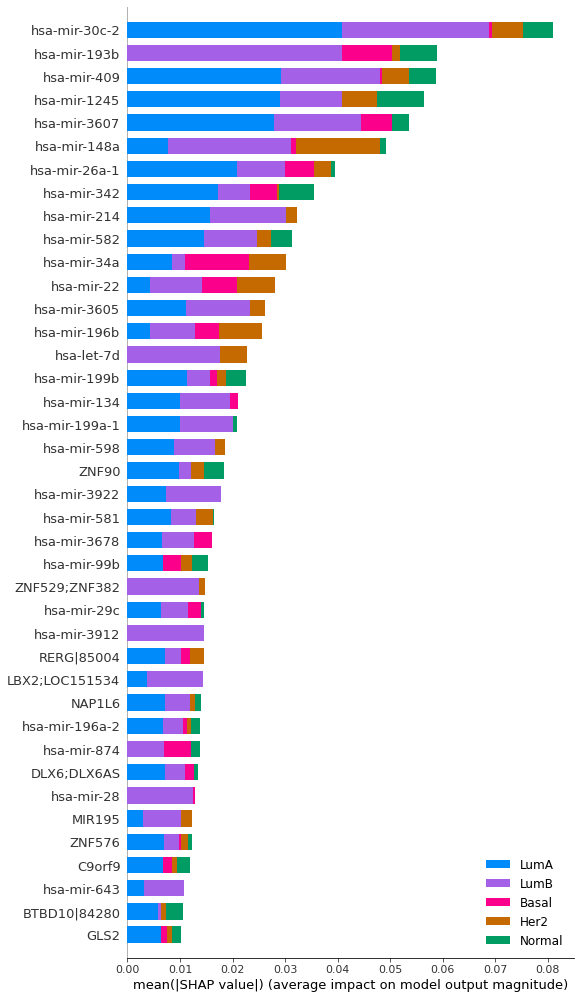

In [109]:
feature_names = [name for sublist in feat_name_list for name in sublist]
shap.summary_plot(shap_values = shap_values, feature_names=feature_names, max_display=40, plot_type='bar', class_names=list(label_dict.keys()))

In [111]:
shap_list = np.sum(np.array([np.mean(abs(each), axis=0) for each in shap_values]), axis=0)
shap_df = pd.DataFrame({"features":feature_names, "shapley_values":shap_list})
shap_df.sort_values(by="features", ascending=True).set_index("features")

,shapley_values
features,
A4GALT|53947,0.000000
AADAT,0.000000
AAGAB,0.000000
AAGAB|79719,0.000000
AATK|9625,0.000170
...,...
hsa-mir-944,0.000000
hsa-mir-95,0.000000
hsa-mir-98,0.000000


In [114]:
raw_shapley_values = np.array(shap_values)
classes = label_dict.keys()
samples = patient_id[0:1]
features = feature_names
names = ['classes', 'samples', 'features']
index = pd.MultiIndex.from_product([range(s)for s in raw_shapley_values.shape], names=names)
#index.set_names(names, inplace=True)
raw_shapley_values = pd.DataFrame({'Shap_values': raw_shapley_values.flatten()}, index=index)['Shap_values']
raw_shapley_values.index = pd.MultiIndex.from_tuples([(x,y,z) for x in classes for y in samples for z in features])
raw_shapley_values.to_csv("raw_shapley_values.csv", index_label=names)
raw_shapley_values

Normal  TCGA-D8-A1XU-01  DBF4|10926        0.000000
                         DACH1|1602        0.000000
                         BBS4|585          0.000000
                         L3MBTL4|91133    -0.000243
                         TK1|7083          0.000000
                                             ...   
LumB    TCGA-D8-A1XU-01  hsa-mir-16-1      0.000000
                         hsa-mir-550a-2    0.000000
                         hsa-mir-24-1      0.000000
                         hsa-mir-508       0.000000
                         hsa-mir-642a      0.000000
Name: Shap_values, Length: 11285, dtype: float64

## SVM
I'll try out svm from the sklearn package here and then extract features from it too.

In [24]:
from sklearn import svm

X = np.array(torch.cat(tuple(each for each in data_tr_list), dim=1))
feature_names = [name for sublist in feat_name_list for name in sublist]
Y = labels_tr_tensor.numpy()

classifier = svm.SVC(probability=True)
classifier.fit(X,Y)

SVC(probability=True)

In [34]:
train_pred = classifier.predict(X)
f1_score(Y, train_pred, average='weighted')

0.940680577020885

In [22]:
X_test = np.array(torch.cat(tuple(each for each in data_trte_list), dim=1))[trte_idx["te"]] #Only test samples
#X_test.shape
test_pred = classifier.predict(X_test)
f1_score(ground_truth_test, test_pred, average='weighted')

0.8174257754619814

In [29]:
#LIME
import lime
import lime.lime_tabular
from lime import submodular_pick

explainer = lime.lime_tabular.LimeTabularExplainer(X, feature_names=feature_names, 
                                                   class_names=label_dict.values(), discretize_continuous=True)

data_full = np.array(torch.cat(tuple(each for each in data_trte_list), dim=1))
sp_obj = submodular_pick.SubmodularPick(explainer, data_full, classifier.predict_proba, method="sample", sample_size=10, num_features=1000, num_exps_desired=5)

In [30]:
W = pd.DataFrame([dict(each.as_list(each.available_labels()[0])) for each in sp_obj.explanations]).fillna(0)
W['prediction'] = [each.available_labels()[0] for each in sp_obj.explanations]

importance = W.groupby("prediction").mean().T   #Mean of lime coefficients by class
importance["aggregate"] = abs(importance).sum(axis=1) #Calculating aggregate importance

new_index = [re.search("(.*)[\>\<]\d*", name).group(1).strip().split(' ')[-1] for name in importance.index]

importance = importance.rename(index=dict(zip(importance.index,new_index)))["aggregate"]
importance = importance.groupby(level=0).sum() 

In [ ]:
importance.to_csv("svm_lime.csv", index_label="features")

In [31]:
average_lime_score = np.mean([each.score for each in sp_obj.explanations])
std_dev = np.std([each.score for each in sp_obj.explanations])
print(average_lime_score, std_dev)

0.5629385617751458 0.04950833630525428


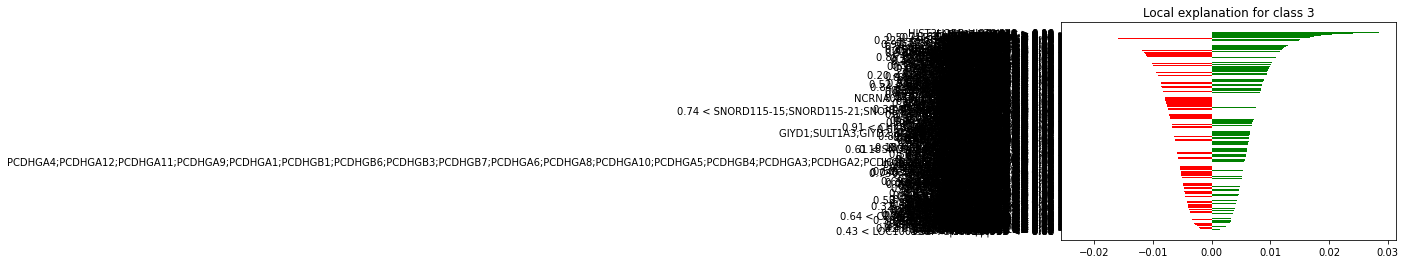

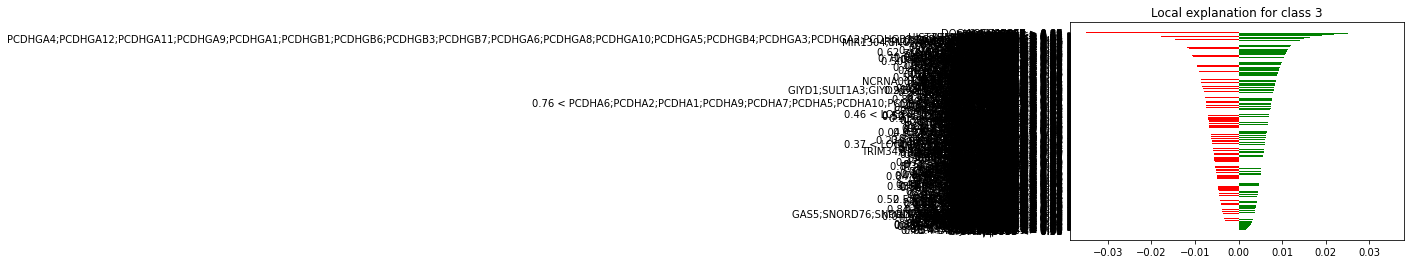

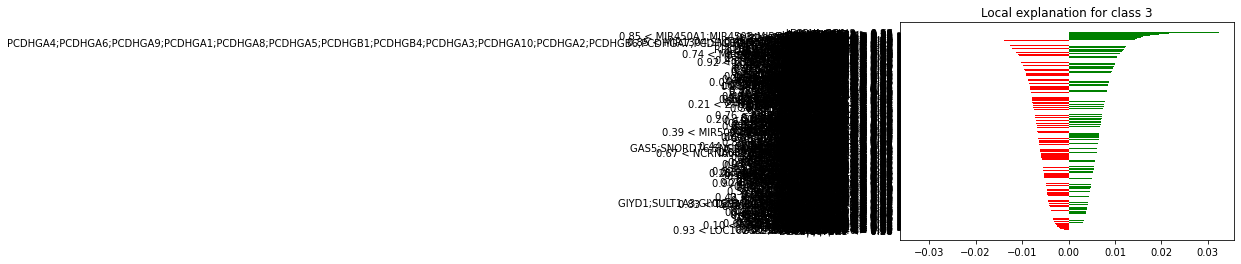

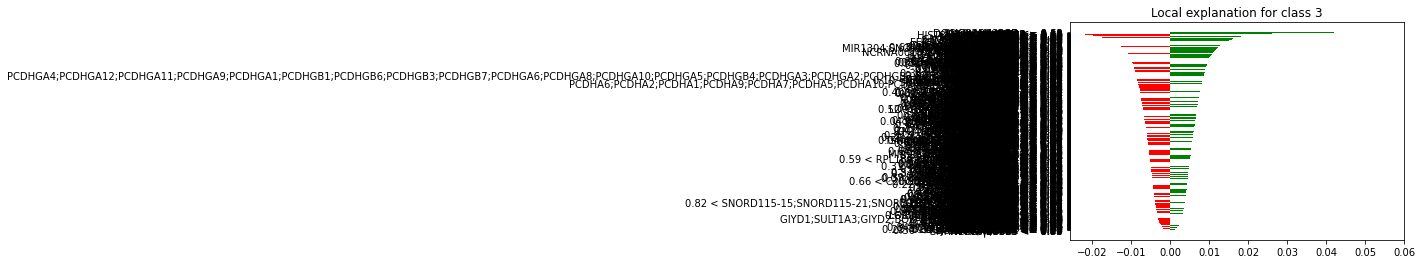

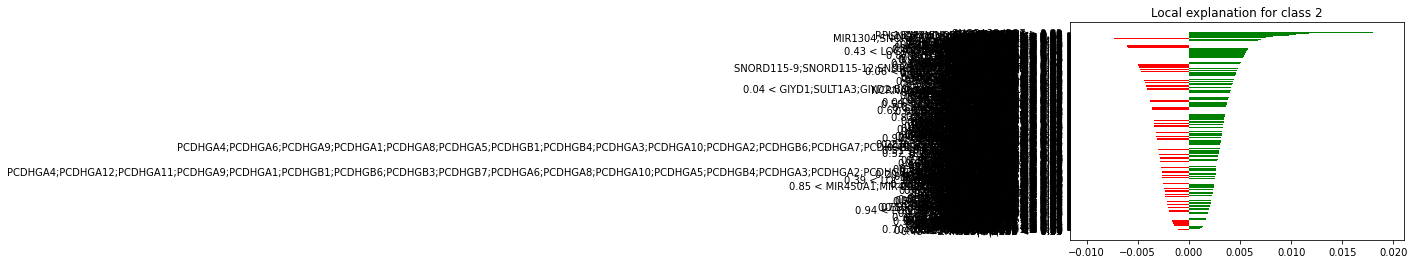

In [33]:
#Plot the explanations
[exp.as_pyplot_figure(label=exp.available_labels()[0]) for exp in sp_obj.sp_explanations];

In [32]:
#Plotting the aggregate importances
np.abs(W.drop("prediction", axis=1)).mean(axis=0).sort_values(ascending=False).head(25).sort_values(
    ascending=True).iplot(kind="barh")
 
#Aggregate importances split by classes
grped_coeff = W.groupby("prediction").mean()
 
grped_coeff = grped_coeff.T
#grped_coeff["abs"] = np.abs(grped_coeff.iloc[:, 0])
grped_coeff["abs"] = abs(grped_coeff).sum(axis=1)
grped_coeff.sort_values("abs", inplace=True, ascending=False)
grped_coeff.head(25).sort_values("abs", ascending=True).drop("abs", axis=1).iplot(kind="barh", bargap=.1)